# Predikce obezity

Na Kaggle jsem si vybral [Obesity Prediction Dataset](https://www.kaggle.com/datasets/ruchikakumbhar/obesity-prediction). Jedná se o klasifikační úlohu. Na základě stravovacích návyků a fyzické kondice budu predikovat váhovou kategorii jedince.

Data si nejprve připravím a prozkoumám jednotlivé příznaky. Poté natrénuji rozhodovací strom. V průběhu budu používat různé metody vizualizace.

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy import stats
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from mlxtend.plotting import plot_decision_regions
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
pd.set_option('display.float_format', '{:.3f}'.format)

# Dataset

In [2]:
df = pd.read_csv("data.csv")
display(df.head())
df.info()
df.nunique()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.000,1.620,64.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,0.000,1.000,no,Public_Transportation,Normal_Weight
1,Female,21.000,1.520,56.000,yes,no,3.000,3.000,Sometimes,yes,3.000,yes,3.000,0.000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000,1.800,77.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,2.000,1.000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000,1.800,87.000,no,no,3.000,3.000,Sometimes,no,2.000,no,2.000,0.000,Frequently,Walking,Overweight_Level_I
4,Male,22.000,1.780,89.800,no,no,2.000,1.000,Sometimes,no,2.000,no,0.000,0.000,Sometimes,Public_Transportation,Overweight_Level_II


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

Gender               2
Age               1402
Height            1574
Weight            1525
family_history       2
FAVC                 2
FCVC               810
NCP                635
CAEC                 4
SMOKE                2
CH2O              1268
SCC                  2
FAF               1190
TUE               1129
CALC                 4
MTRANS               5
Obesity              7
dtype: int64

V datasetu je 2111 záznamů a žádné chybějící hodnoty. Příznaků je 17, představím je.

- Gender - pohlaví
- Age - věk v letech
- Height - výška v metrech
- Weight - váha v kilogramech
- family_history - má nějaký rodinný příbuzný nadváhu?
- FAVC - jí často vysoce kalorické jídlo?
- FCVC - jak často jí zeleninu
- NCP - počet hlavních jídel za den
- CAEC - jí nějaké jídlo mezi hlavními jídly?
- SMOKE - kouří?
- CH2O - kolik vody denně vypije
- SCC - kontroluje si kalorie, které denně sní?
- FAF - jak často provozuje nějakou fyzickou aktivitu
- TUE - kolik času tráví používáním technologií
- CALC - jak často pije alkohol
- MTRANS - jaký způsob dopravy využívá
- **Obesity** - váhová kategorie (vysvětlovaná proměnná)

Příznaky *Age*, *Height*, *Weight*, *FCVC*, *NCP*, *CH2O*, *FAF*, *TUE* jsou numerické, ostatní jsou kategorické.

In [3]:
numerical_features = list(df.select_dtypes("float64").columns)
categorical_features = list(df.select_dtypes("object").columns)

## Pohlaví, věk, výška, váha

,Frequency,Relative frequency
Male,1068,0.506
Female,1043,0.494


,Age,Height,Weight
Min,14.000,1.450,39.000
Max,61.000,1.980,173.000
Average,24.313,1.702,86.586
25%,19.947,1.630,65.473
Median,22.778,1.700,83.000
75%,26.000,1.768,107.431


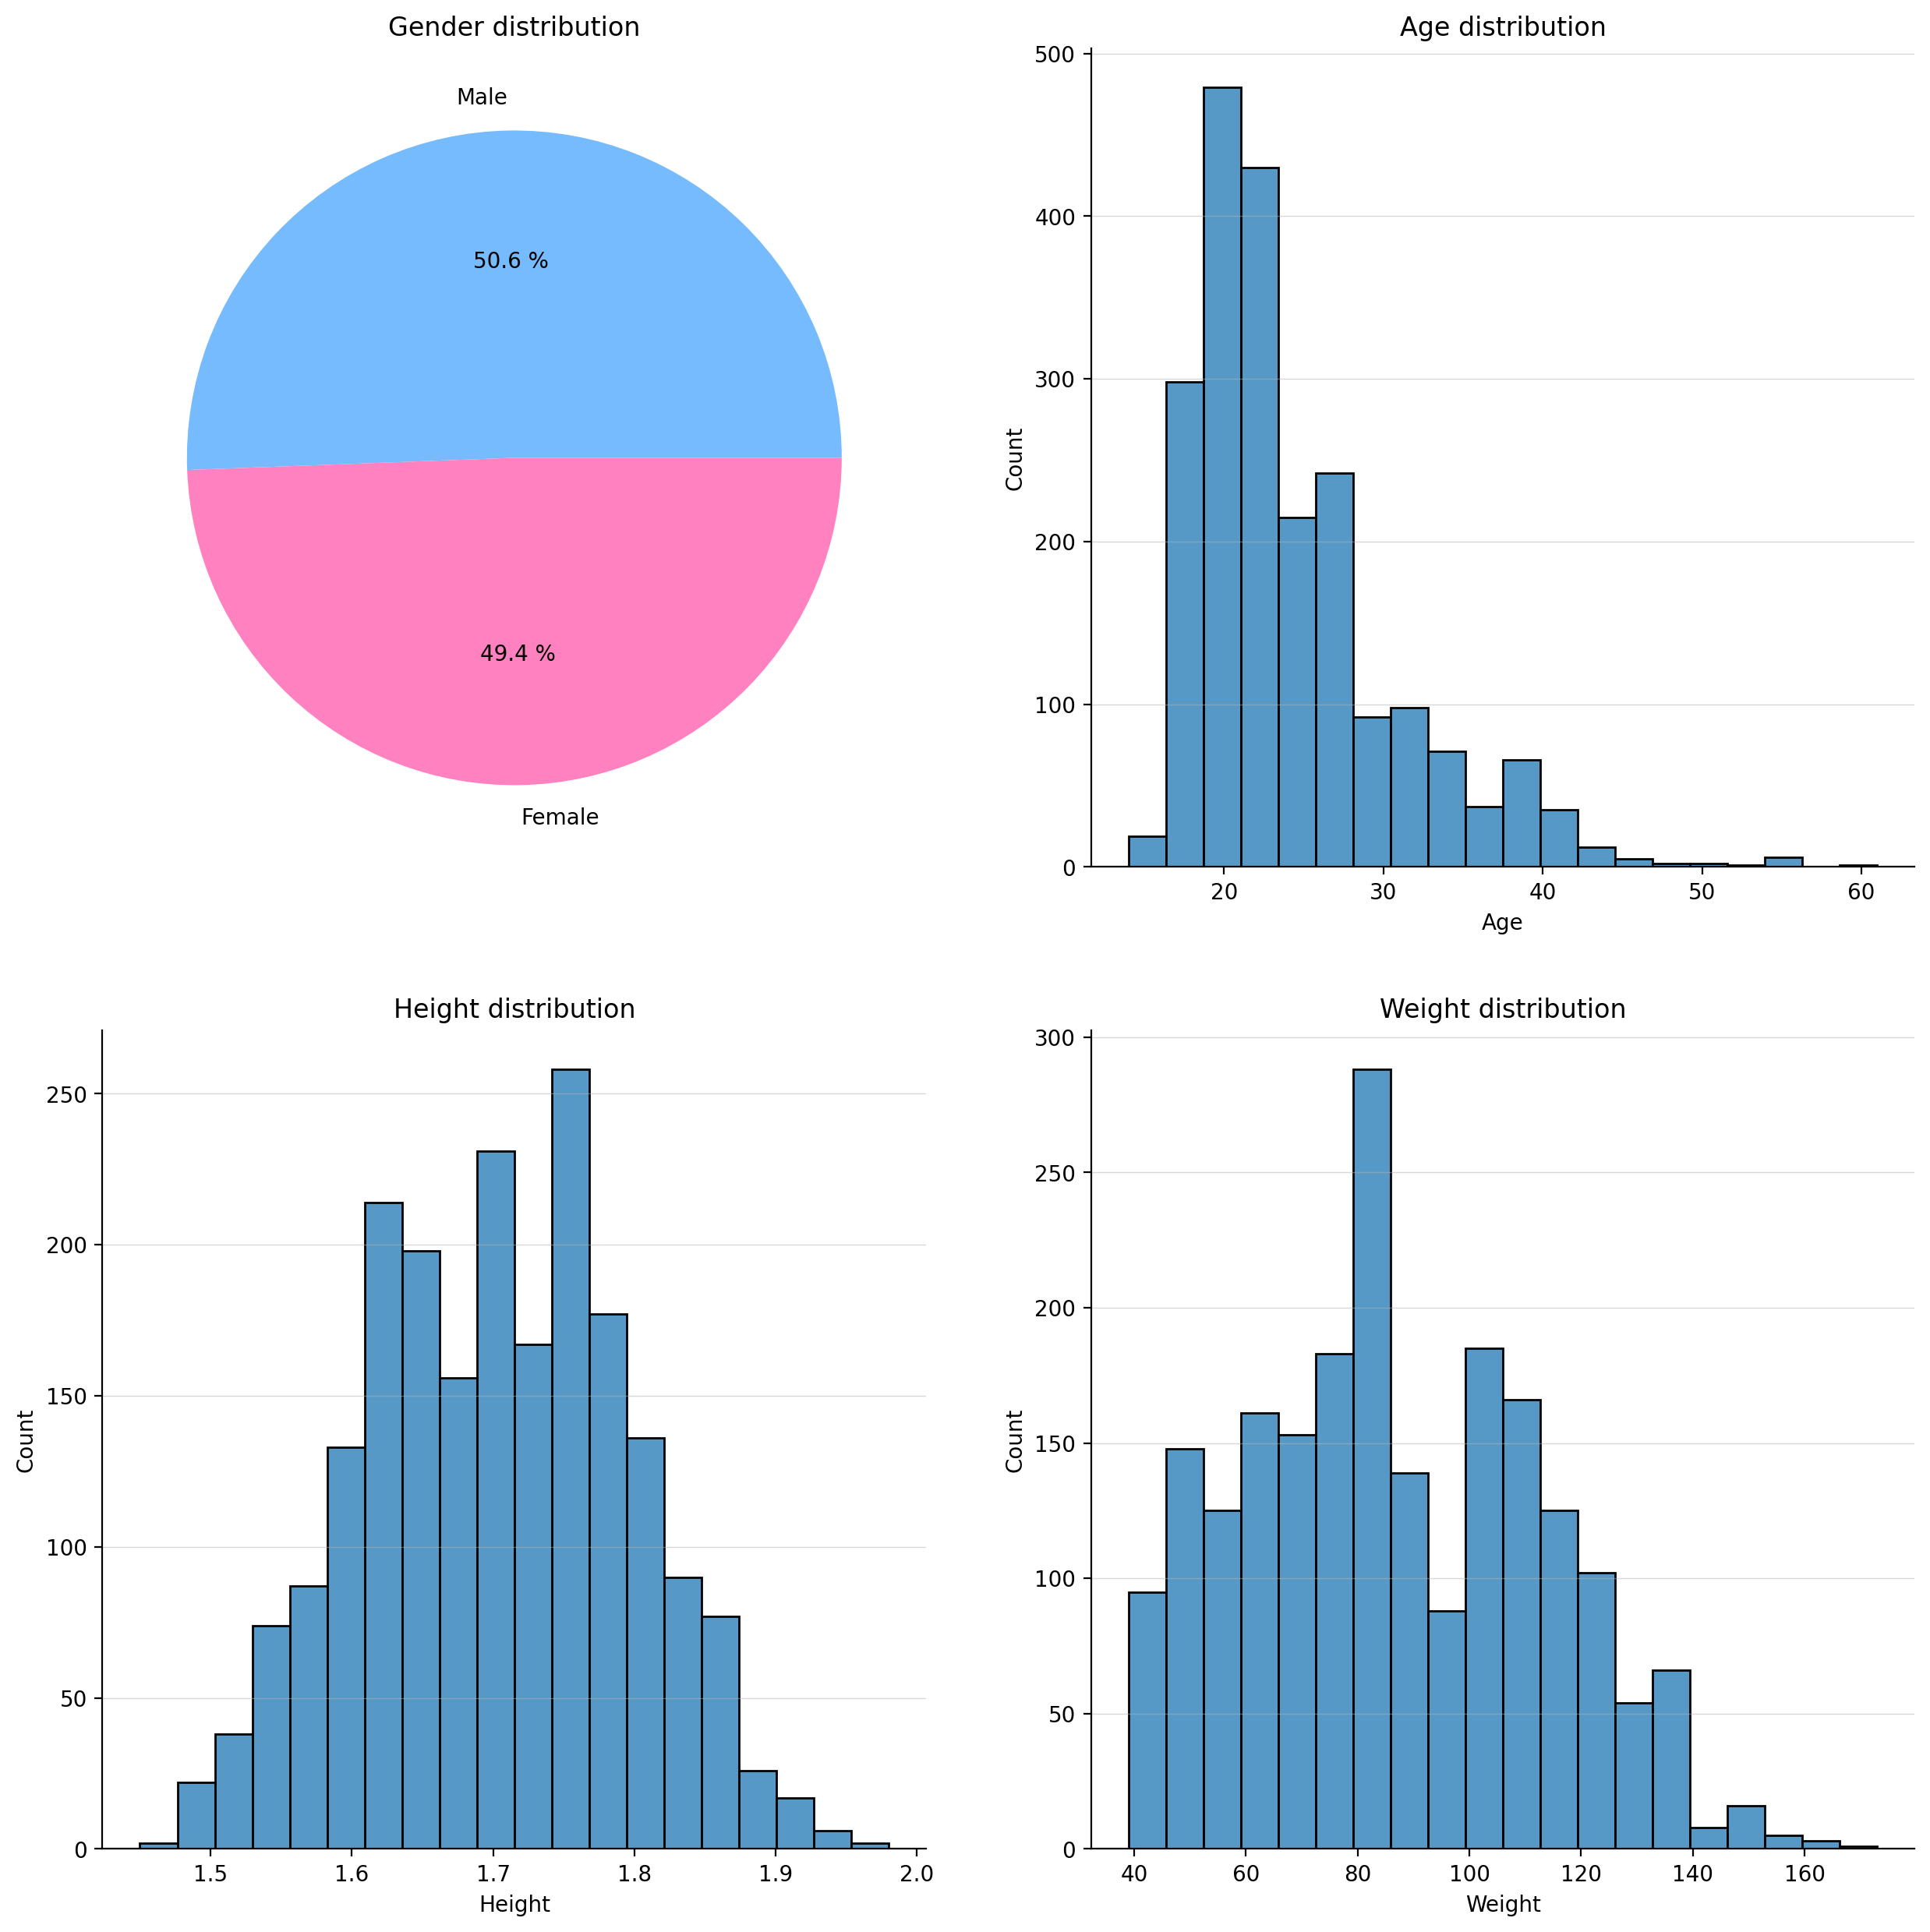

In [4]:
# Returns a dataframe with frequencies and relative frequencies of categories in the given column
def get_stats_df_categorical(df, col):
    dictionary = {
        "Frequency": df[col].value_counts(),
        "Relative frequency": df[col].value_counts(normalize=True),
    }
    return pd.DataFrame(dictionary)

# Returns a dataframe with min, max, mean, median and 25 and 75 quantiles of the given columns
def get_stats_df_numerical(df, columns, titles):
    dictionary = dict()
    for col, title in zip(columns, titles):
        dictionary[title] = [
            df[col].min(),
            df[col].max(),
            df[col].mean(),
            df[col].quantile(0.25),
            df[col].median(),
            df[col].quantile(0.75),
        ]
    return pd.DataFrame(dictionary, index=["Min", "Max", "Average", "25%", "Median", "75%"])

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

display(get_stats_df_categorical(df, "Gender"))
display(get_stats_df_numerical(df, ["Age", "Height", "Weight"], ["Age", "Height", "Weight"]))

# Gender
ax1.set_title("Gender distribution")
ax1.pie(df["Gender"].value_counts(), labels=df["Gender"].value_counts().index, autopct='%1.1f %%', colors=["xkcd:sky blue", "xkcd:pink"])

# Age
ax2.spines[["top", "right"]].set_visible(False)
ax2.set_xlabel("Age")
ax2.set_ylabel("Count")
ax2.set_title("Age distribution")
ax2.grid(axis="y", alpha=0.5, linewidth=0.5)
sns.histplot(df["Age"], ax=ax2, bins=20)

# Height
ax3.spines[["top", "right"]].set_visible(False)
ax3.set_xlabel("Height")
ax3.set_ylabel("Count")
ax3.set_title("Height distribution")
ax3.grid(axis="y", alpha=0.5, linewidth=0.5)
sns.histplot(df["Height"], ax=ax3, bins=20)

# Weight
ax4.spines[["top", "right"]].set_visible(False)
ax4.set_xlabel("Weight")
ax4.set_ylabel("Count")
ax4.set_title("Weight distribution")
ax4.grid(axis="y", alpha=0.5, linewidth=0.5)
sns.histplot(df["Weight"], ax=ax4, bins=20);

Lze vidět, že ženy a muži jsou zastoupeni téměř rovnoměrně. Většině respondentů je mezi 20 a 30 lety, ale nejmladšímu respondentovi je 14, nejstaršímu 61. Výška se pohybuje zejména mezi 1.6 a 1.8 metru a váha mezi 60 a 110 kg, ale nejtěžší respondent váží 173 kg.

## Váhové kategorie

Podívejme se, jaké jsou váhové kategorie, které budeme predikovat.

,Frequency,Relative frequency
Obesity_Type_I,351,0.166
Obesity_Type_III,324,0.153
Obesity_Type_II,297,0.141
Overweight_Level_I,290,0.137
Overweight_Level_II,290,0.137
Normal_Weight,287,0.136
Insufficient_Weight,272,0.129


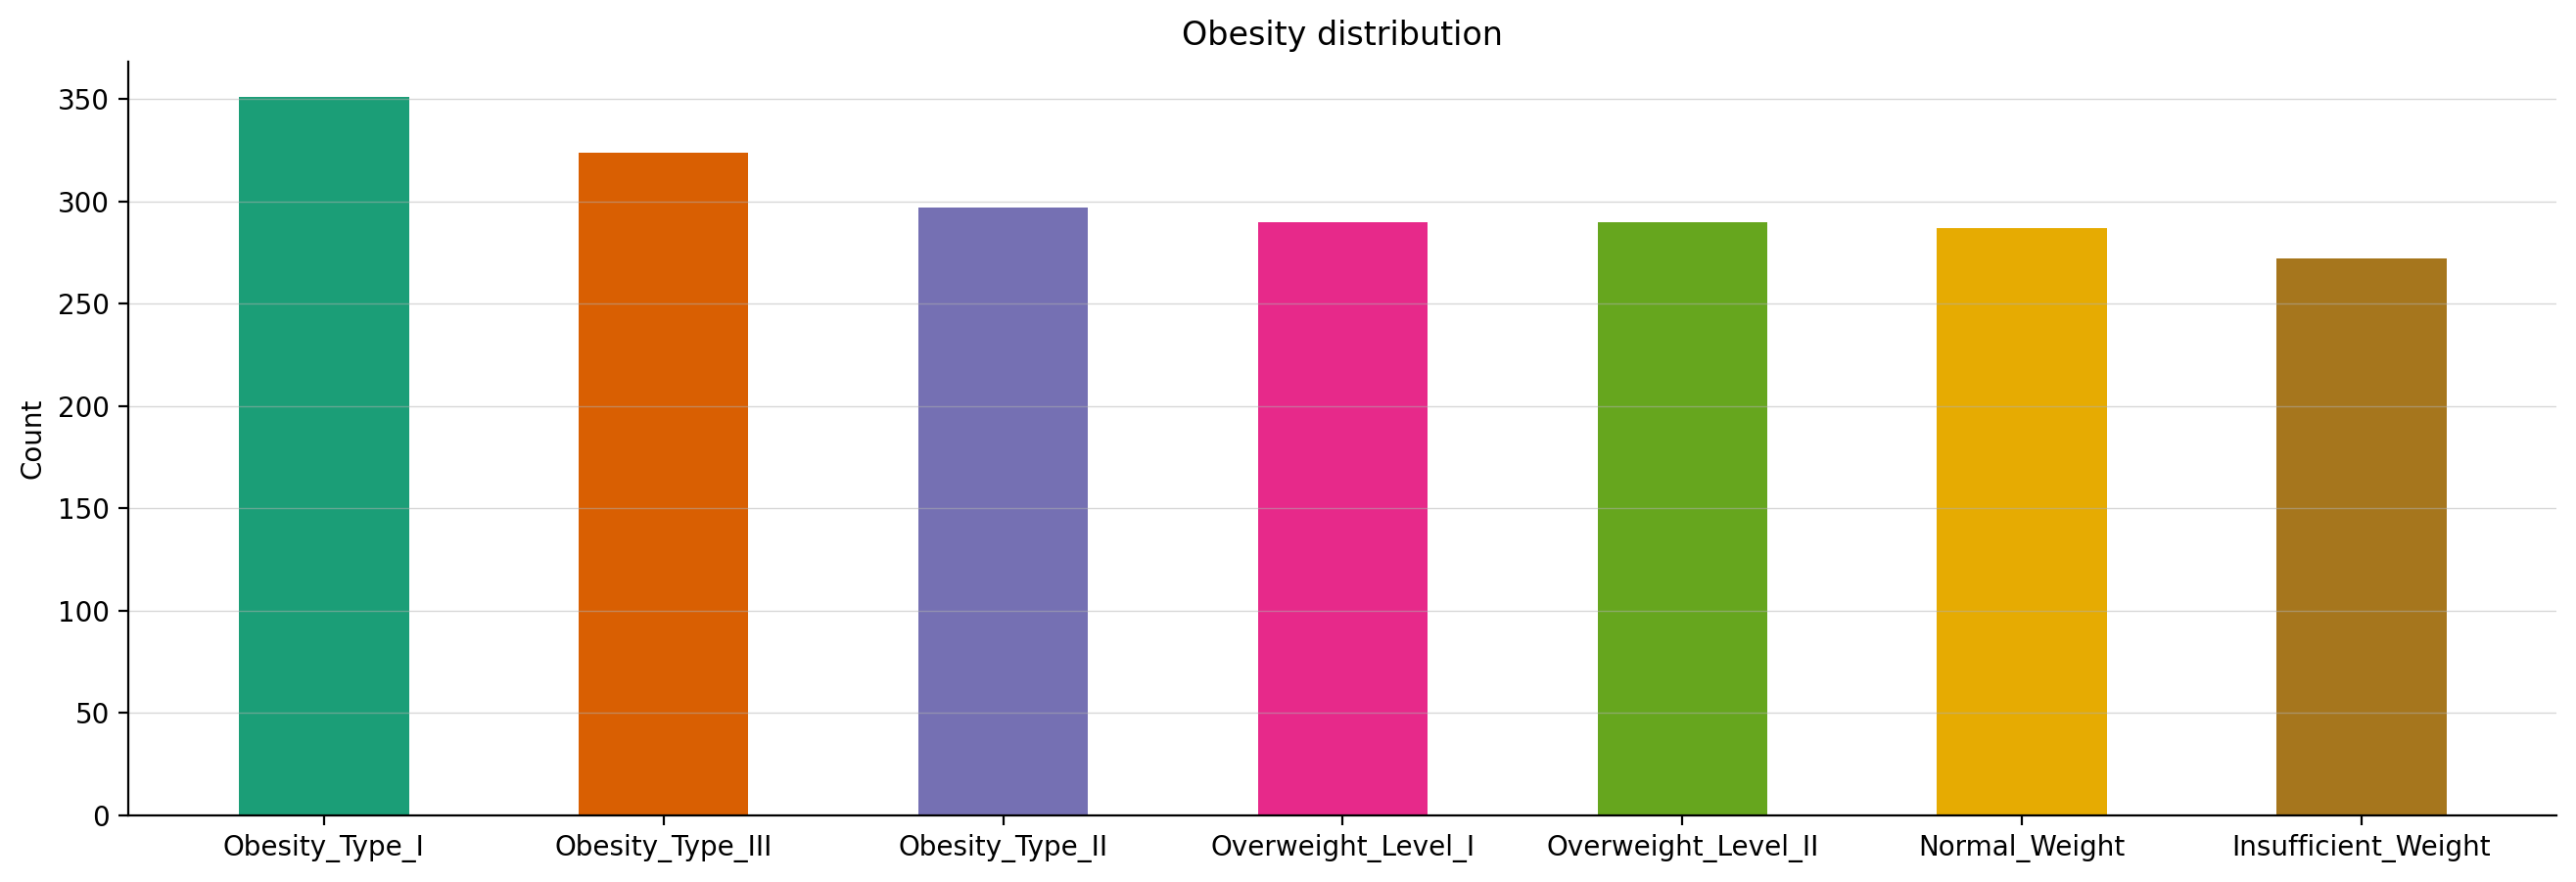

In [5]:
display(get_stats_df_categorical(df, "Obesity"))

fig, ax = plt.subplots(figsize=(16, 5))

ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Count")
ax.set_title("Obesity distribution")
ax.grid(axis="y", alpha=0.5, linewidth=0.5)
ax.bar(df["Obesity"].value_counts().index, df["Obesity"].value_counts(), width=0.5, color=plt.cm.Dark2.colors);

Vidíme, že váhových kategorií je sedm a jsou poměrně rovnoměrně rozdělené. Jde o ordinální příznak, pořadí je *Insufficient Weight*, *Normal Weight*, *Overweight Level I*, *Overweight Level II*, *Obesity Type I*, *Obesity Type II* and *Obesity Type III*. 

,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
Min,39.000,42.300,53.000,60.000,75.000,93.000,102.000
Max,65.000,87.000,91.000,102.000,125.000,130.000,173.000
Average,49.906,62.155,74.267,82.085,92.870,115.305,120.941
25%,44.657,55.000,68.152,78.030,82.141,112.011,109.492
Median,50.000,61.000,75.000,82.000,90.745,117.792,112.049
75%,53.668,68.500,80.000,86.850,103.738,120.806,133.503


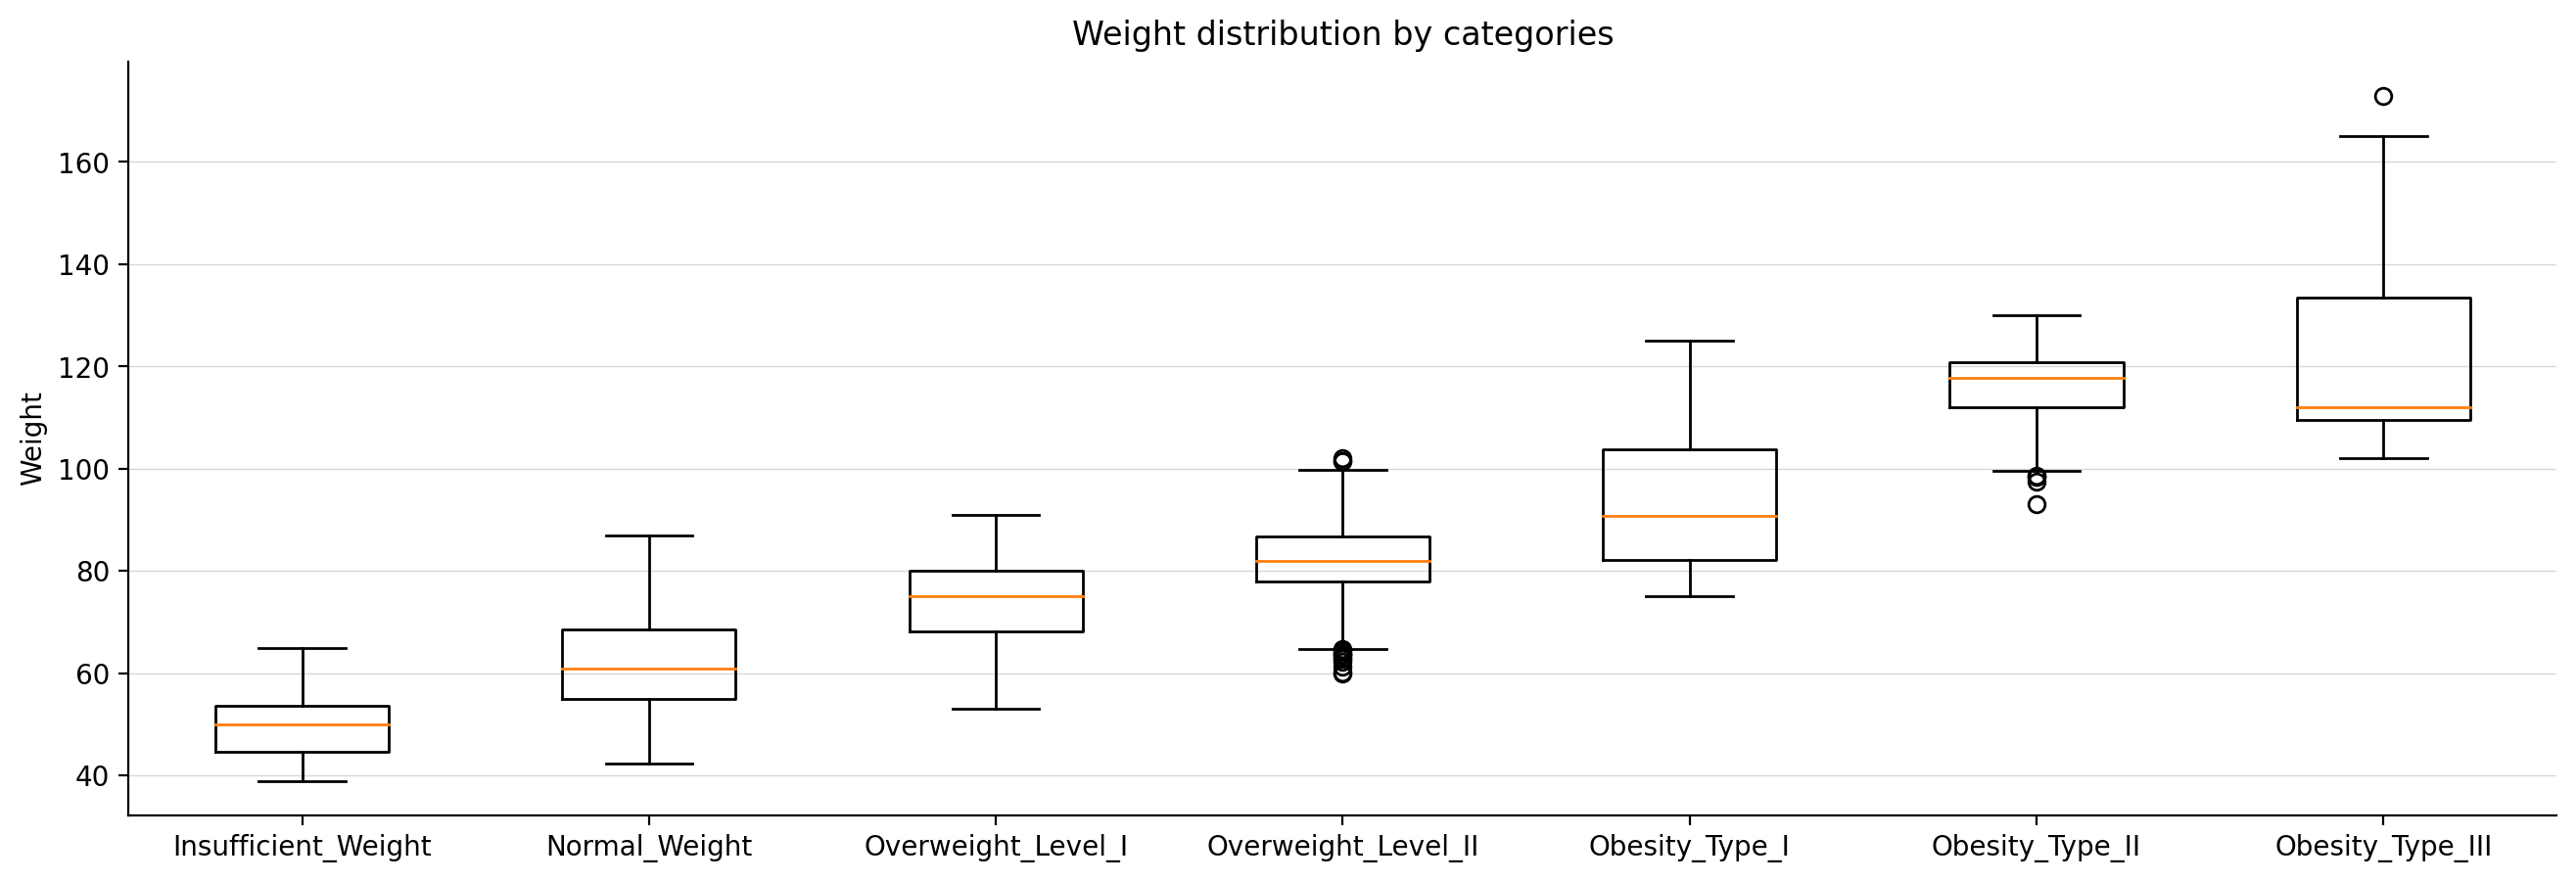

In [6]:
labels = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
data = [df[df["Obesity"] == category] for category in labels]
weights = [dataframe["Weight"] for dataframe in data]
stats = []
for i, category in enumerate(labels):
    stats.append(get_stats_df_numerical(data[i], ["Weight"], [category]))
display(pd.concat(stats, axis=1))

fig, ax = plt.subplots(figsize=(16, 5))
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Weight")
ax.set_title("Weight distribution by categories")
ax.grid(axis="y", alpha=0.5, linewidth=0.5)
ax.boxplot(weights, labels=labels);

V tabulce a na boxplotech vidíme, v jakých hodnotách se pohybuje váha jednotlivých kategorií. Někde dochází k překryvu, to dává smysl, protože normální váha dvoumetrového muže bude pravděpodobně vyšší než zvýšená váha ženy vysoké 1.5 metru.

## Chybějící a odlehlé hodnoty

Viděli jsme, že žádné chybějící hodnoty v datasetu nejsou, ale mohou být reprezentované jinak než `NaN` hodnotou. Zkontroluji to.

In [7]:
print("Unique values by column")
for col in categorical_features:
    print(f"{col}:", df[col].unique())

Unique values by column
Gender: ['Female' 'Male']
family_history: ['yes' 'no']
FAVC: ['no' 'yes']
CAEC: ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE: ['no' 'yes']
SCC: ['no' 'yes']
CALC: ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Obesity: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Ve sloupcích s kategorickými příznaky žádné chybějící hodnoty nejsou. U numerických příznaků mohou být reprezentované např. záporným číslem, ověřím to.

In [8]:
df.describe().loc[["min"]]

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
min,14.000,1.450,39.000,1.000,1.000,1.000,0.000,0.000


Vypadá to, že chybějící hodnoty nejsou ani ve sloupcích s numerickými příznaky. Prozkoumejme ještě odlehlé hodnoty.

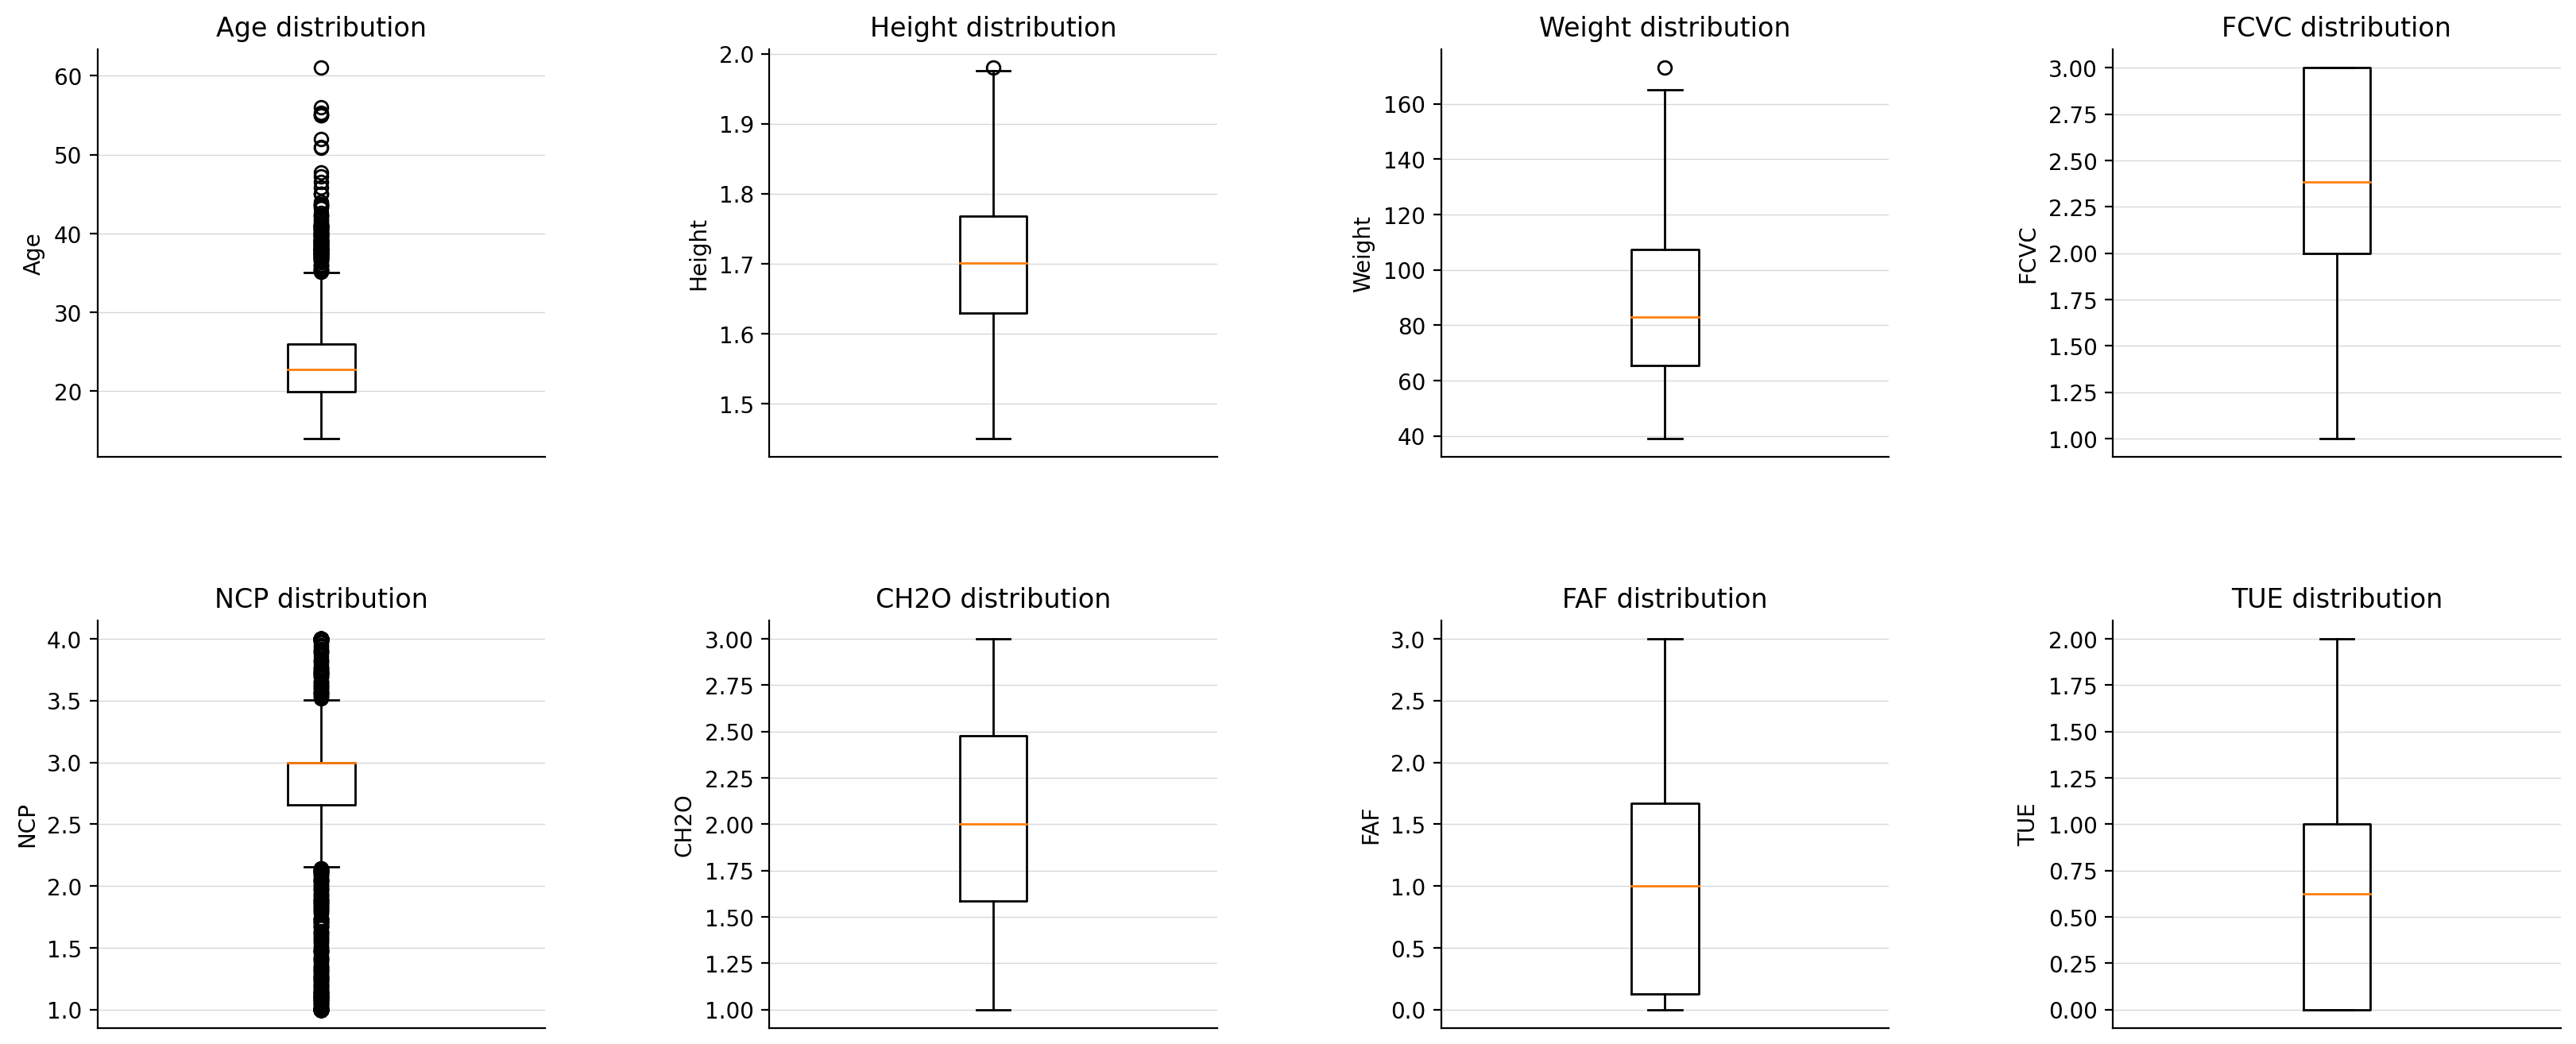

In [9]:
fig = plt.figure(figsize=(20, 8))
ax = [fig.add_subplot(2, 4, i) for i in range(1, 9)]
fig.subplots_adjust(wspace=0.5, hspace=0.4)

for i, col in enumerate(numerical_features):
    ax[i].spines[["top", "right"]].set_visible(False)
    ax[i].set_title(f"{col} distribution")
    ax[i].set_ylabel(col)
    ax[i].tick_params(axis="x", bottom=False, labelbottom=False)
    ax[i].grid(axis="y", alpha=0.5, linewidth=0.5)
    ax[i].boxplot(df[col])

Vidíme, že odlehlé hodnoty jsou pouze ve sloupcích *Age*, *Height*, *Weight* a *NCP*. Z předchozího pozorování víme, že v případě věku, výšky a váhy nejde o nesmyslné hodnoty. *NCP* je počet hlavních jídel za den, hodnoty se pohybují mezi 1 a 4, ale většina lidí jí tři jídla denně, to také dává smysl.

,NCP
Min,1.000
Max,4.000
Average,2.686
25%,2.659
Median,3.000
75%,3.000


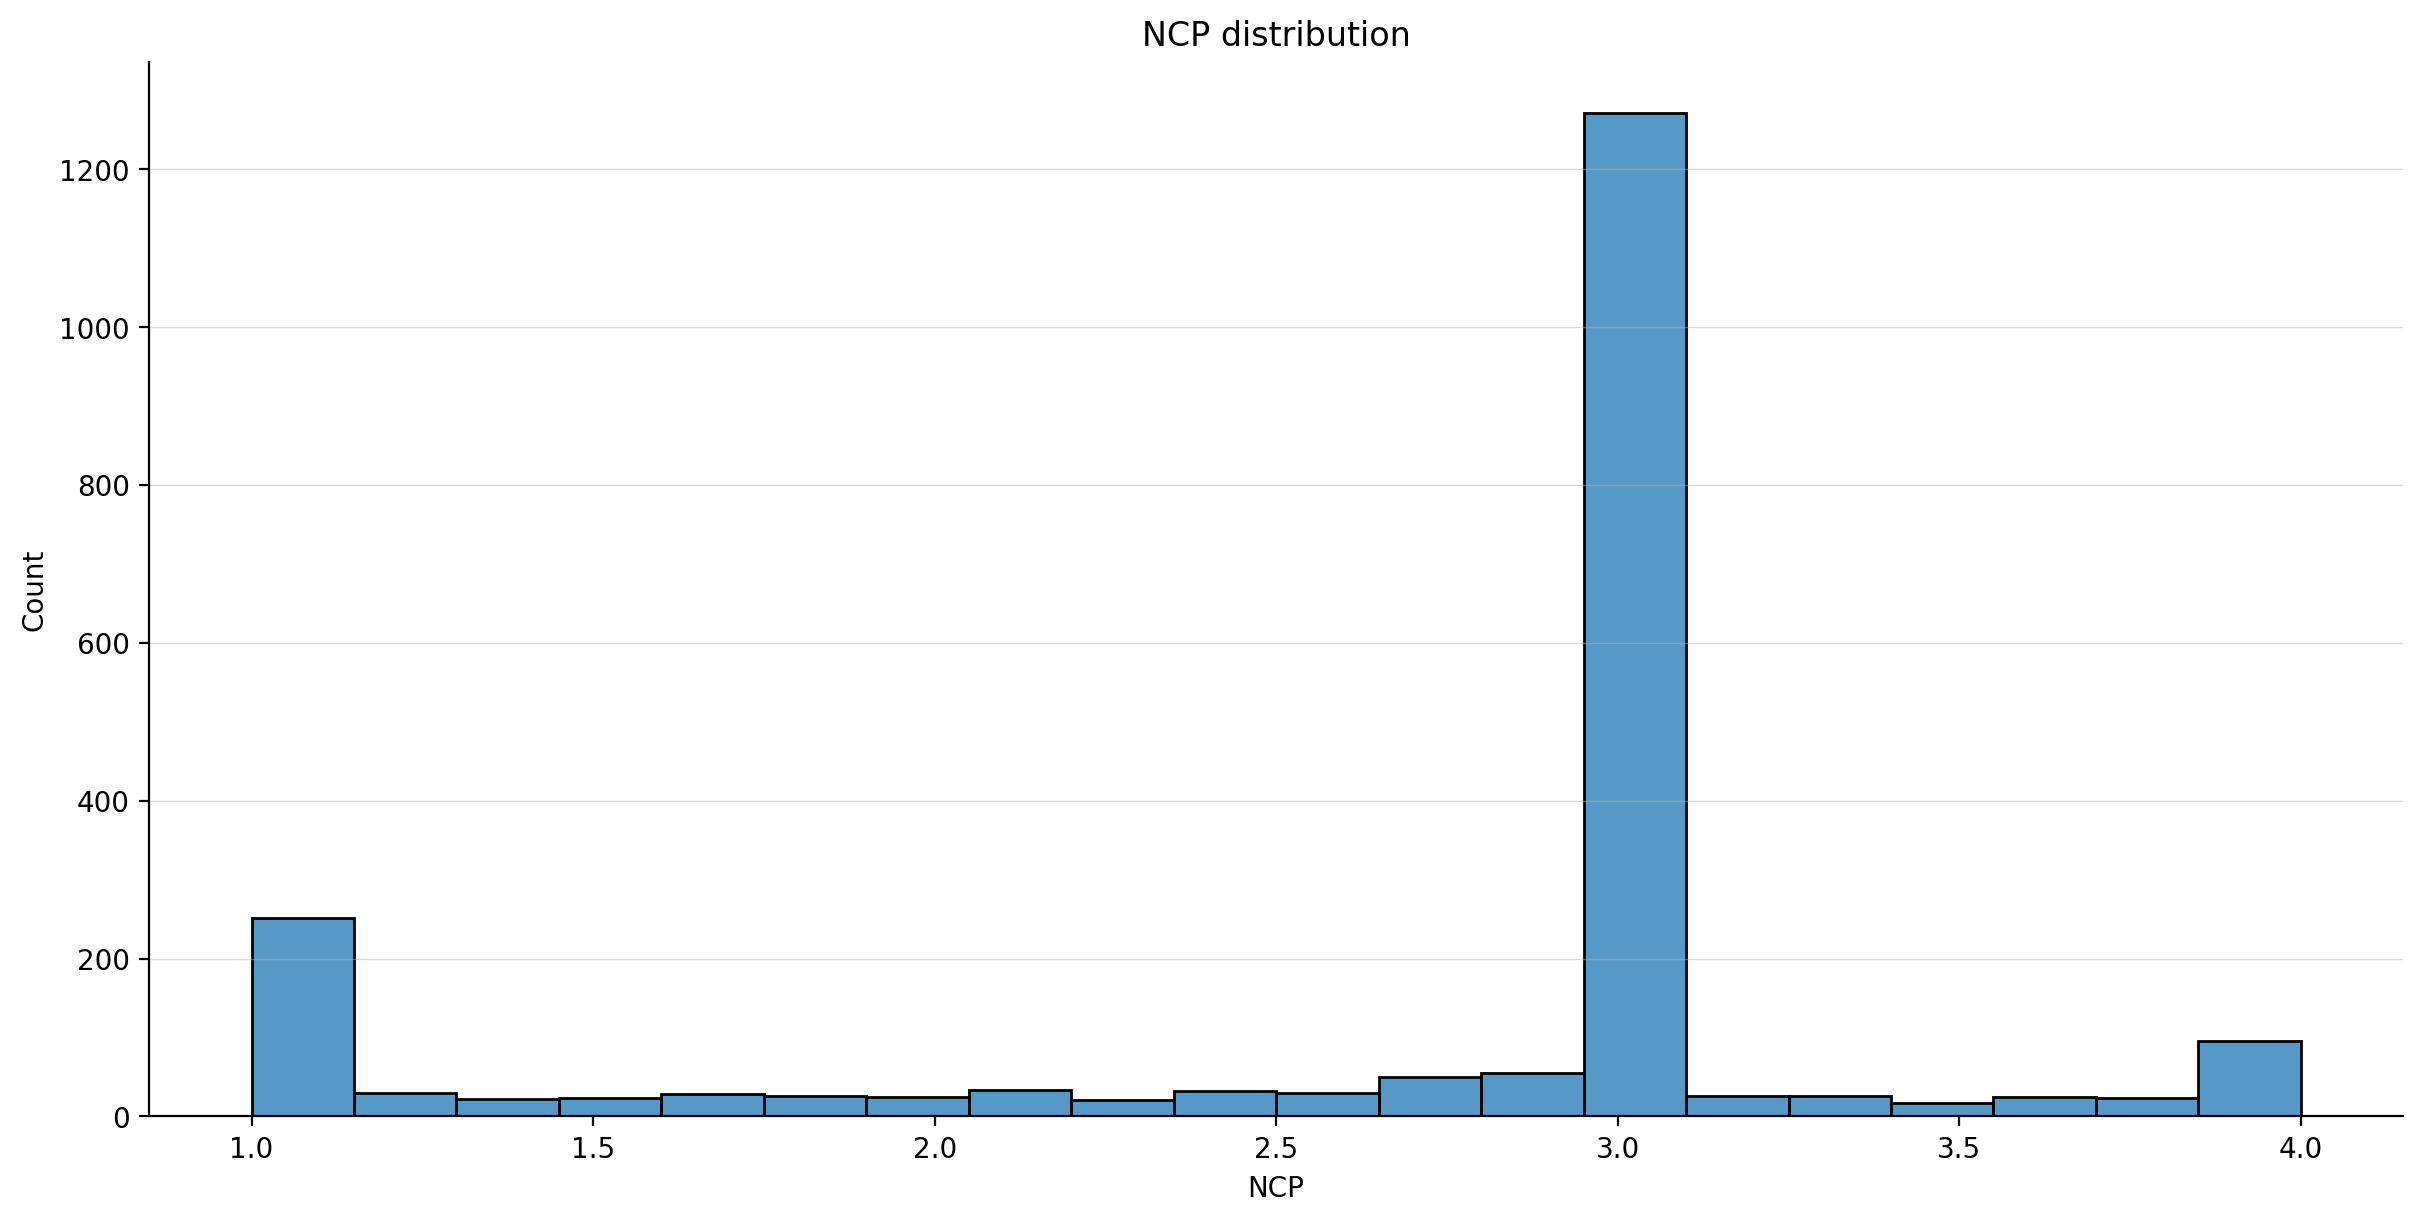

In [10]:
display(get_stats_df_numerical(df, ["NCP"], ["NCP"]))

fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("NCP")
ax.set_ylabel("Count")
ax.set_title("NCP distribution")
ax.grid(axis="y", alpha=0.5, linewidth=0.5)
sns.histplot(df["NCP"], ax=ax, bins=20);

## Příprava dat

Abych mohl predikovat, musím kategorické příznaky převést na číselnou reprezentaci.

### Ordinální příznaky

Ordinální příznaky převedu na čísla 0, 1, 2, ... podle pořadí kategorií. Jde o příznaky *CAEC*, *CALC* a *Obesity*.

In [11]:
print("Obesity categories:")
print(df["Obesity"].unique())

print("\nCAEC categories:")
print(df["CAEC"].unique())

print("\nCALC categories:")
print(df["CALC"].unique())

obesity_cats = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
caec_cats = ["no", "Sometimes", "Frequently", "Always"]
calc_cats = ["no", "Sometimes", "Frequently", "Always"]

obesity_type = pd.CategoricalDtype(obesity_cats, ordered=True)
caec_type = pd.CategoricalDtype(caec_cats, ordered=True)
calc_type = pd.CategoricalDtype(calc_cats, ordered=True)

df["Obesity"] = df["Obesity"].astype(obesity_type).cat.codes
df["CAEC"] = df["CAEC"].astype(caec_type).cat.codes
df["CALC"] = df["CALC"].astype(calc_type).cat.codes

Obesity categories:
['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']

CAEC categories:
['Sometimes' 'Frequently' 'Always' 'no']

CALC categories:
['no' 'Sometimes' 'Frequently' 'Always']


### Nominální příznaky

Příznaky mající jen dvě kategorie (*Gender*, *family_history*, *FAVC*, *SMOKE*, *SCC*) převedu na nuly a jedničky. Na příznak *MTRANS* s více kategoriemi použiju one-hot encoding.

In [12]:
df["Gender"] = df["Gender"].astype("category").cat.codes
df["family_history"] = df["family_history"].astype("category").cat.codes
df["FAVC"] = df["FAVC"].astype("category").cat.codes
df["SMOKE"] = df["SMOKE"].astype("category").cat.codes
df["SCC"] = df["SCC"].astype("category").cat.codes

In [13]:
df = pd.get_dummies(df, columns=["MTRANS"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        2111 non-null   int8   
 1   Age                           2111 non-null   float64
 2   Height                        2111 non-null   float64
 3   Weight                        2111 non-null   float64
 4   family_history                2111 non-null   int8   
 5   FAVC                          2111 non-null   int8   
 6   FCVC                          2111 non-null   float64
 7   NCP                           2111 non-null   float64
 8   CAEC                          2111 non-null   int8   
 9   SMOKE                         2111 non-null   int8   
 10  CH2O                          2111 non-null   float64
 11  SCC                           2111 non-null   int8   
 12  FAF                           2111 non-null   float64
 13  TUE

Data si rozdělím na trénovací, validační a testovací množinu v poměru 6:2:2. Zároveň oddělím vysvětlovanou proměnnou *Obesity*.

In [14]:
Xdata = df.drop("Obesity", axis=1)
Ydata = df["Obesity"]

random_seed = 333

Xtrain, Xrest, Ytrain, Yrest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=random_seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xrest, Yrest, test_size=0.5, random_state=random_seed)

# Model

## Trénování

K predikci budu používat rozhodovací strom. Z datasetu odeberu příznak *Weight*, jinak by se predikovalo primárně podle něj. Ladit budu následující hyperparametry:

- max_depth - maximální hloubka stromu
- min_samples_split - minimální počet vzorků v listu, aby se ještě rozdělovalo dál
- min_samples_leaf - minimální počet vzorků, které musí být listu

Nejlepší model vyberu podle přesnosti na validačních datech.

In [15]:
Xtrain = Xtrain.drop("Weight", axis=1)
Xval = Xval.drop("Weight", axis=1)
Xtest = Xtest.drop("Weight", axis=1)

In [16]:
param_grid = {
    "max_depth": range(1, 22),
    "min_samples_split": range(2, 7),
    "min_samples_leaf": range(1, 7),
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    clf_tmp = DecisionTreeClassifier(**params, random_state=random_seed)
    clf_tmp.fit(Xtrain, Ytrain)
    val_acc.append(metrics.accuracy_score(Yval, clf_tmp.predict(Xval)))
    train_acc.append(metrics.accuracy_score(Ytrain, clf_tmp.predict(Xtrain)))
best_params = param_comb[np.argmax(val_acc)]
display(best_params)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 18}

In [17]:
clf = DecisionTreeClassifier(**best_params, random_state=random_seed)
clf.fit(Xtrain, Ytrain)
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clf.predict(Xval)):.4f}")

Validation accuracy: 0.7938


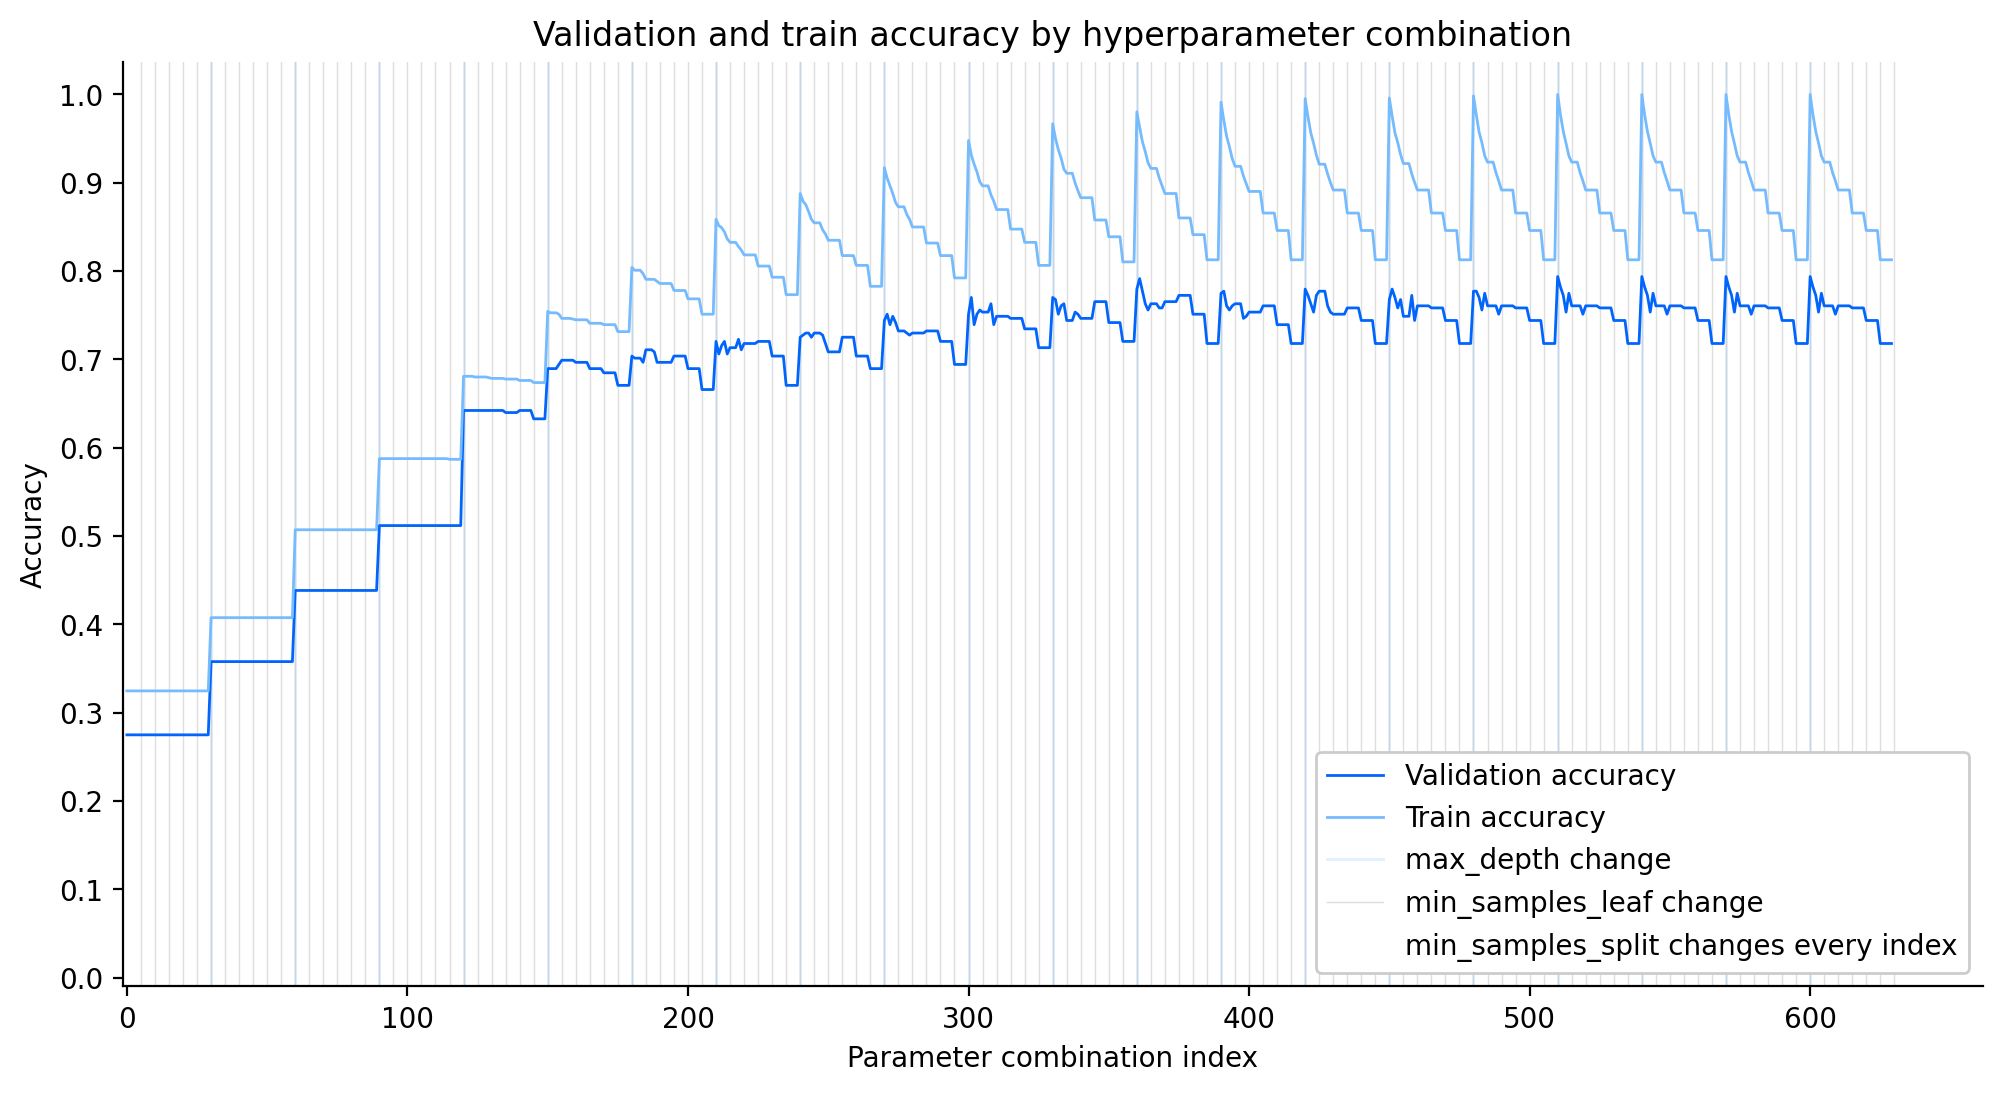

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

for x in range(30,30 * 21,30):
    ax.axvline(x=x, c="xkcd:baby blue", linewidth=1, label='max_depth change', alpha=0.3)

for x in range(5,5 * 127,5):
    ax.axvline(x=x, c="xkcd:grey", linewidth=0.5, label='min_samples_leaf change', alpha=0.3)

for i, params in enumerate(param_comb):
    if params == best_params:
        best_index = i

ax.plot(val_acc, label="Validation accuracy", color="xkcd:bright blue", linewidth=1)
ax.plot(train_acc, label="Train accuracy", color="xkcd:sky blue", linewidth=1)
ax.set_xlabel("Parameter combination index")
ax.set_ylabel("Accuracy")
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlim(left=-1.5)
ax.set_ylim(bottom=-0.01)
ax.set_title("Validation and train accuracy by hyperparameter combination")
ax.set_yticks(np.linspace(0, 1, 11))

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
labels = ["Validation accuracy", "Train accuracy", "max_depth change", "min_samples_leaf change"]
handles = [by_label[label] for label in labels]
labels.append("min_samples_split changes every index")
handles.append(Patch(color="white", label=labels[-1]))
ax.legend(handles, labels, framealpha=1);

Pro malé hloubky byl model poměrně nepřesný a nezáleželo na hodnotách `min_samples_leaf` a `min_samples_split`. U vyšších hloubek měl model nejlepší přesnost pro nízké `min_samples_leaf`. Naopak `min_samples_split` měl vliv jen u nižších hodnot `min_samples_leaf`, pro vyšší hodnoty přesnost moc neovlivňoval (vodorovné "schody").

## Finální model

Nejlepší kombinace hyperparametrů má přesnost na validační množině 79.38 %. Jde o hodnoty hyperparametrů:

- min_samples_split: 2
- min_samples_leaf: 1
- max_depth: 18

Jelikož má strom hloubku 18, byla by jeho celá vizualizace nepřehledná, proto se podíváme jen na první čtyři hladiny.

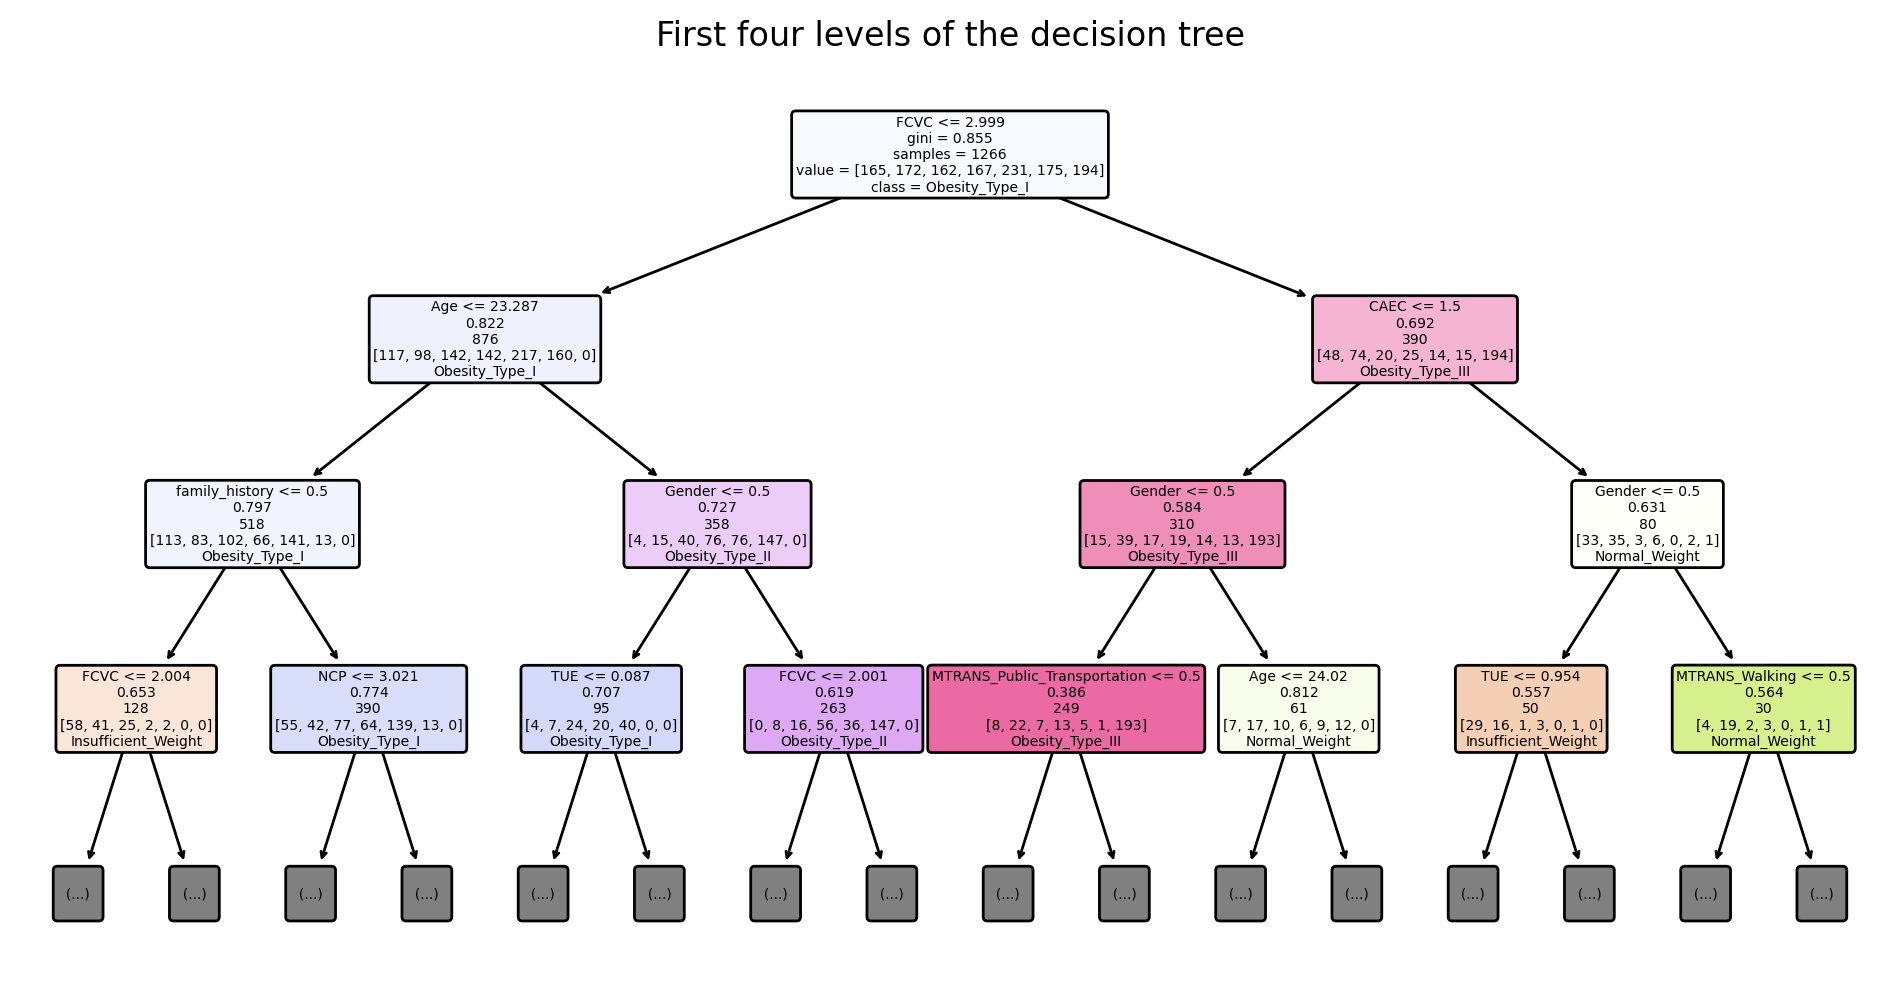

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_tree(clf, feature_names=Xtrain.columns, class_names=obesity_cats, filled=True, rounded=True, ax=ax, fontsize=5, max_depth=3, label="root")
ax.set_title("First four levels of the decision tree");

Vidíme, že první rozhodnutí je podle hodnoty příznaku *FCVC* (jak často jí zeleninu). Dělení v dalších vrcholech probíhá podle různých příznaků, jde např. o *Gender* (pohlaví), *Age* (věk), *TUE* (čas strávený používáním technologií) nebo *NCP* (počet hlavních jídel denně).

Rozhodovací hranici není možné vizualizovat, jelikož dataset má moc velkou dimenzi. Kdybych si vybral dva příznaky pro kreslení rozhodovací hranice, musel bych ostatní příznaky doplnit nějakou hodnotou a vizualizace by mohla být matoucí. Např. muž výšky 1.75 metru může patřit do různé váhové kategorie v závislosti na ostatních příznacích, to by vizualizace nezachytila.

In [20]:
print("Dimenze datasetu:", Xtrain.shape[1])

Dimenze datasetu: 19


## Úspěšnost

Na testovací množině změřím odhad přesnosti na nových datech, nakreslím matici záměn a One-vs-Rest ROC křivku pro každou váhovou kategorii.

In [21]:
print(f"Odhad přesnosti: {metrics.accuracy_score(Ytest, clf.predict(Xtest)):.4f}")

Odhad přesnosti: 0.7612


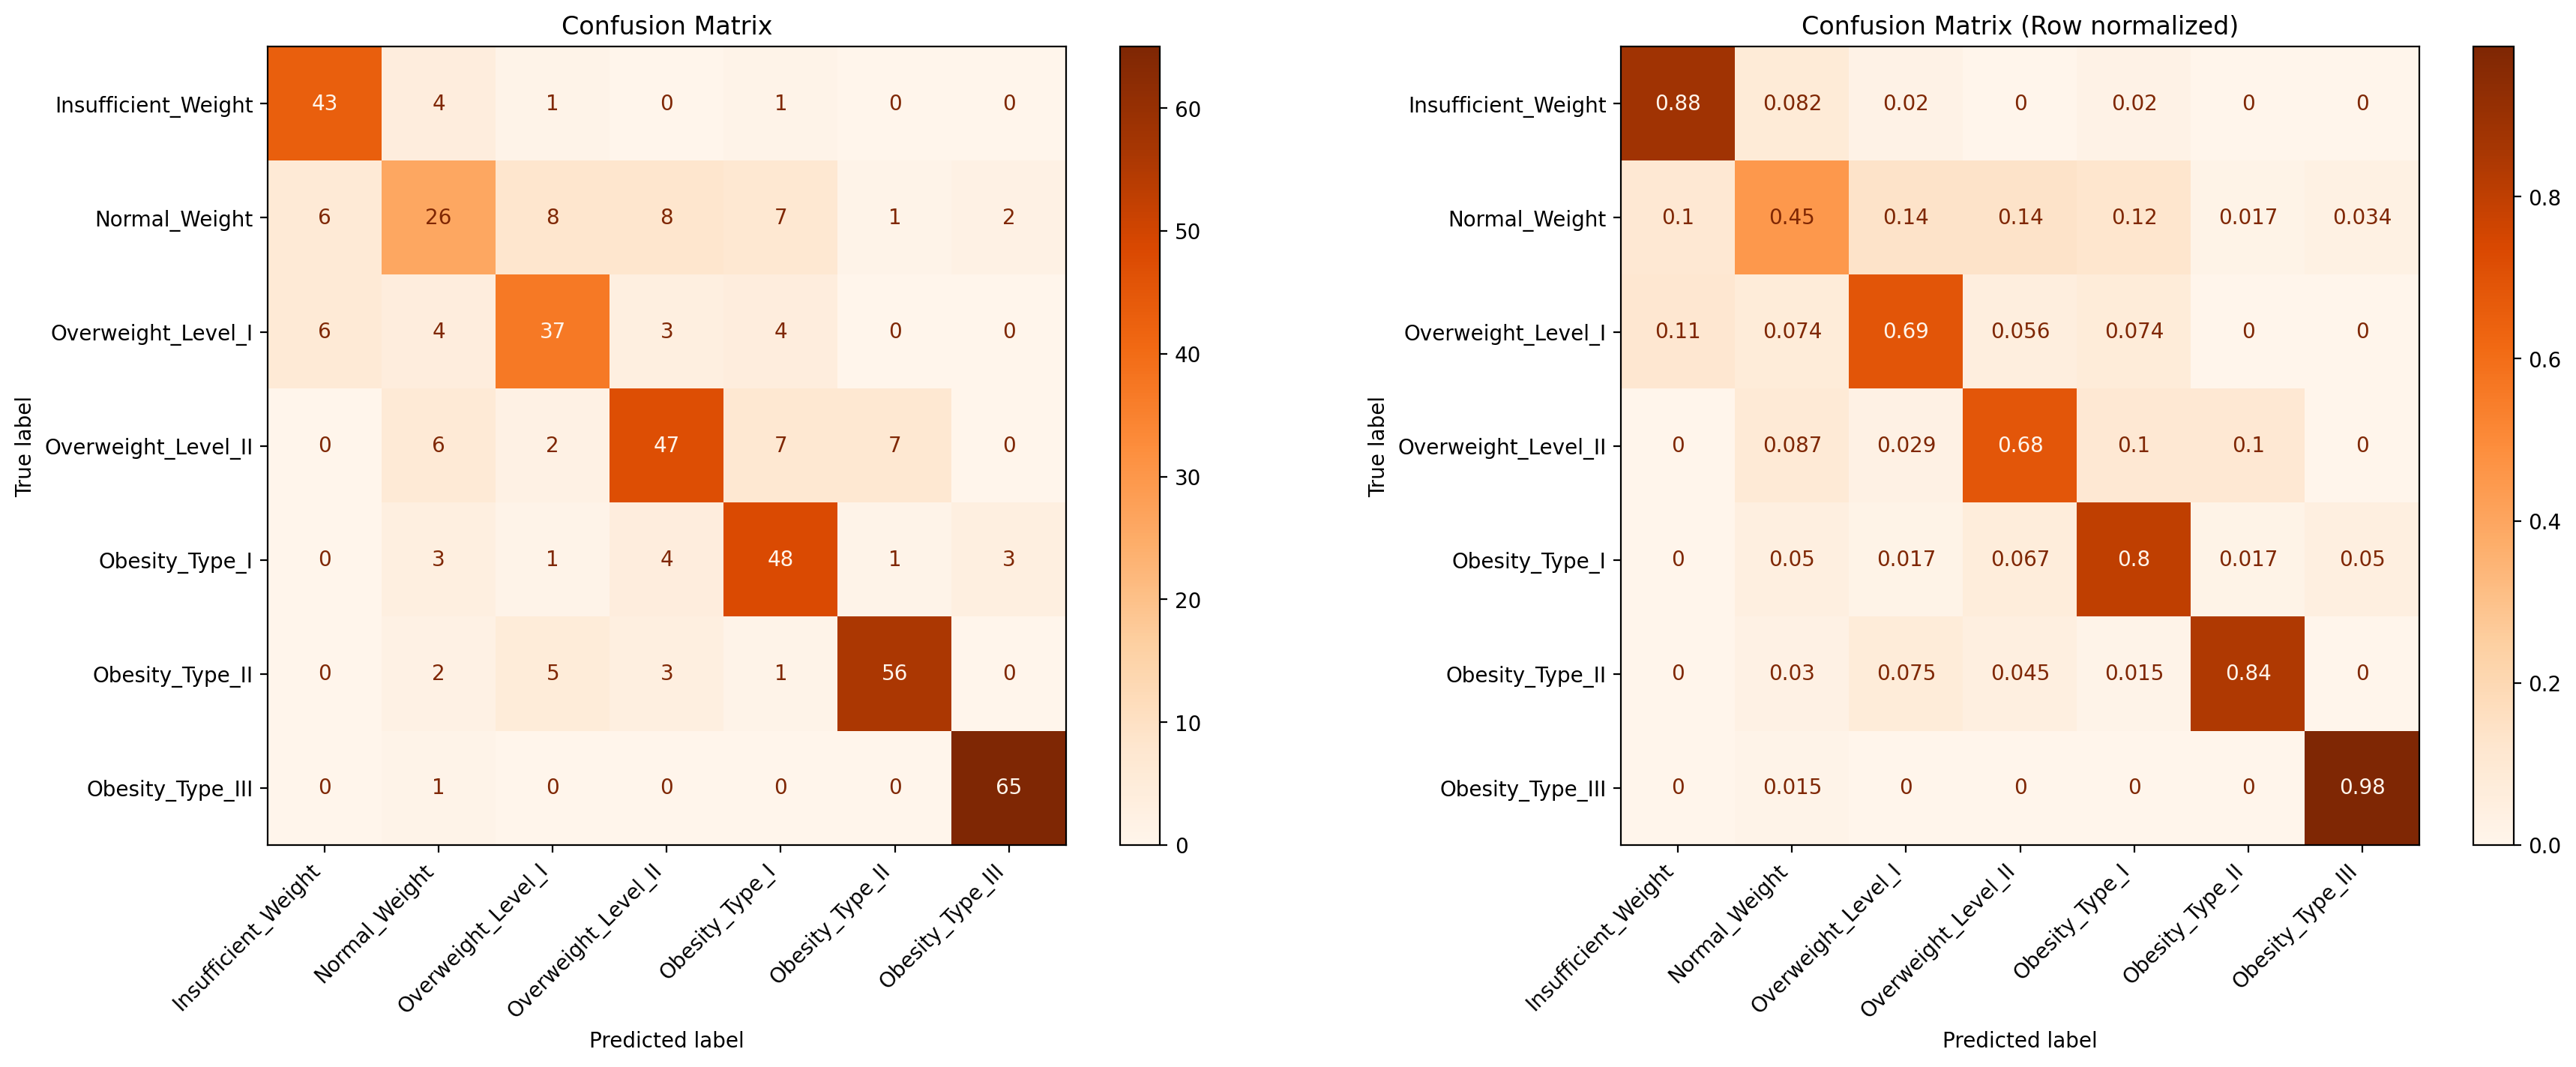

In [22]:
fig = plt.figure(figsize=(18, 7), constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

metrics.ConfusionMatrixDisplay.from_estimator(clf, Xtest, Ytest, ax=ax1, cmap="Oranges")
metrics.ConfusionMatrixDisplay.from_estimator(clf, Xtest, Ytest, ax=ax2, cmap="Oranges", normalize="true")

ax1.set_title("Confusion Matrix")
ax2.set_title("Confusion Matrix (Row normalized)")
ax1.set_xticklabels(obesity_cats)
ax1.set_yticklabels(obesity_cats)
ax2.set_xticklabels(obesity_cats)
ax2.set_yticklabels(obesity_cats)

for i, label in enumerate(ax1.get_xticklabels()):
    label.set(rotation=45, ha="right")
for label in ax2.get_xticklabels():
    label.set(rotation=45, ha="right")

Vidíme, že kategorie *Obesity Type III* byla předpovězena správně v 98 % případů. Přesnost na kategoriích *Insufficient Weight*, *Obesity Type I* a *Obesity Type II* se pohybuje mezi 75 a 80 procenty. Naopak přesnost na kategoriích *Normal Weight*, *Overweight Level I* a *Overweight Level II* je jen o trochu lepší než 50 %.

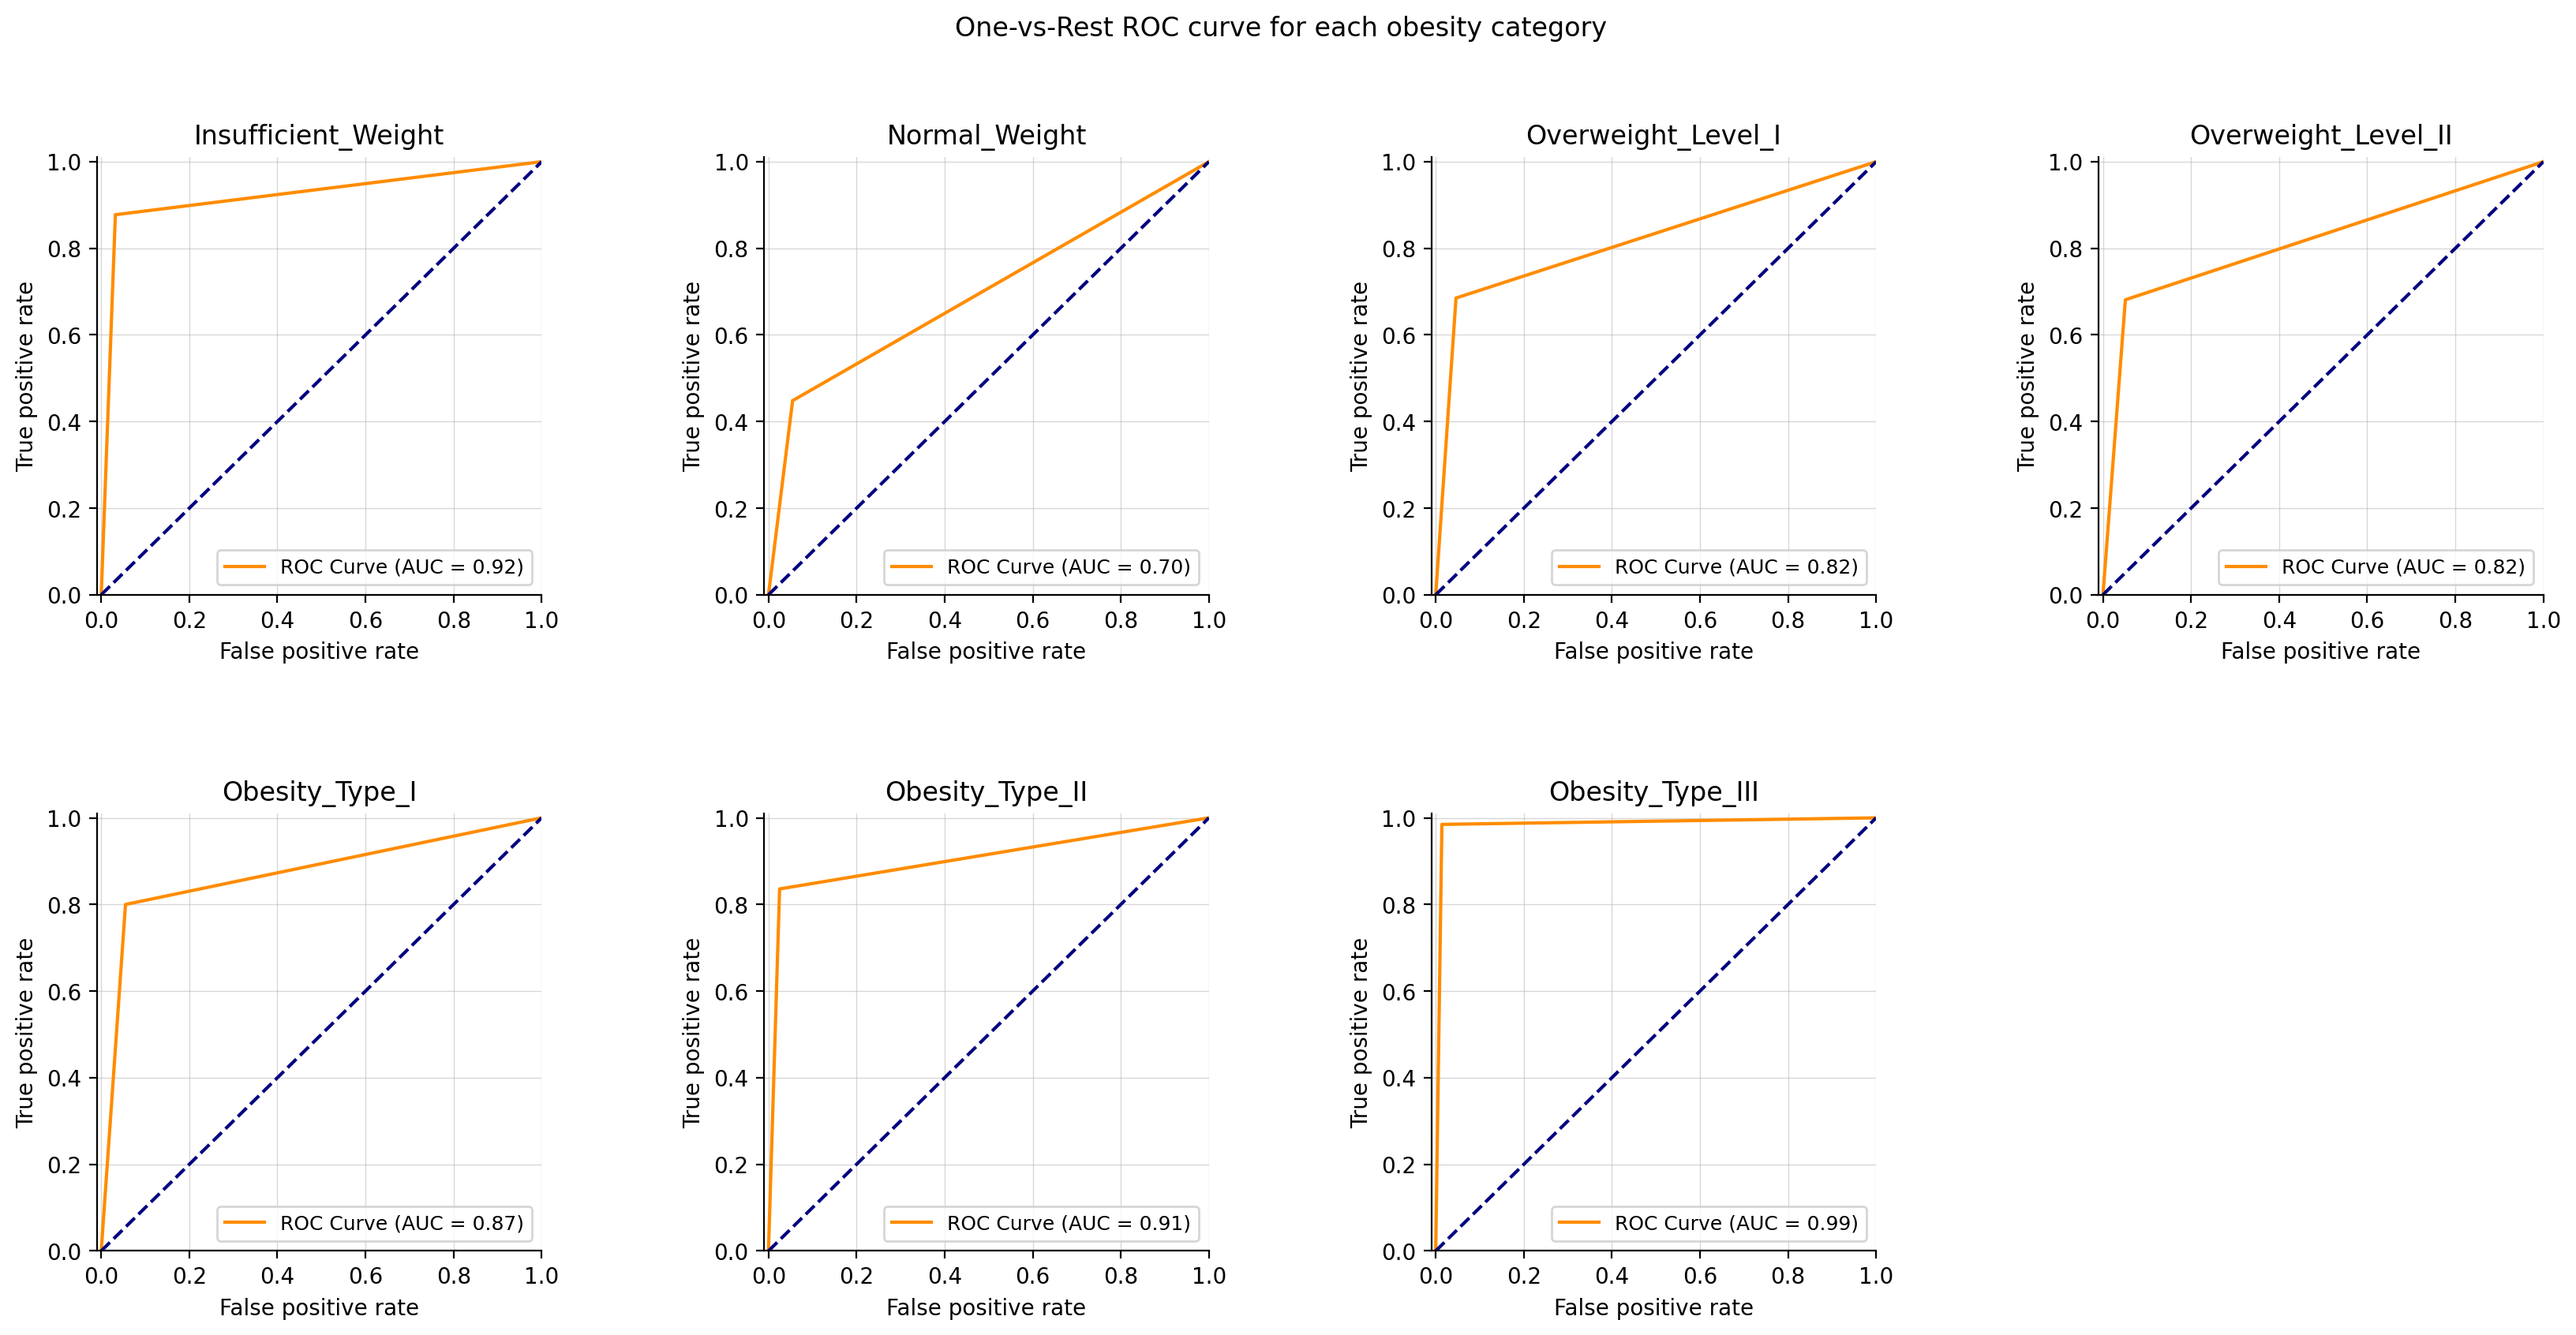

In [23]:
label_binarizer = LabelBinarizer().fit(Ytrain)
Yonehot = label_binarizer.transform(Ytest)
Ypred_proba = clf.predict_proba(Xtest)

fig = plt.figure(figsize=(20, 9))
ax = [fig.add_subplot(2, 4, i) for i in range(1, 8)]
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("One-vs-Rest ROC curve for each obesity category")

for i in range(7):
    metrics.RocCurveDisplay.from_predictions(Yonehot[:, i], Ypred_proba[:, i], ax=ax[i], color="darkorange")
    ax[i].spines[["top", "right"]].set_visible(False)
    ax[i].set_title(f"{obesity_cats[i]}")
    ax[i].set_ylabel("True positive rate")
    ax[i].set_xlabel("False positive rate")
    ax[i].grid(alpha=0.5, linewidth=0.5)
    ax[i].set_xlim([-0.01, 1])
    ax[i].set_ylim([0, 1.01])
    ax[i].plot([0, 1], [0, 1], color="navy", linestyle="--")
    handles, labels = ax[i].get_legend_handles_labels()
    labels[0] = labels[0].replace("Classifier", "ROC Curve")
    ax[i].legend(handles, labels, fontsize=9, loc="lower right")

ROC křivky potvrzují to, co říká matice záměn. U *Obesity Type III* je AUC dokonce 0.99.

# Závěr

Připravil jsem si dataset, abych mohl pomocí rozhodovacího stromu predikovat váhovou kategorii. Svůj postup jsem doplňoval vizualizacemi.